In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from context_analysis.load import load_spike_proba, load_behaviour
from context_analysis.reshape import split_by_group, split_by_mouse
from context_analysis.resample import downsample, temporally_align_onep_behaviour
from context_analysis.onep.preprocessing import block_from_time, remove_nan_ys, remove_mixed_ys
from context_analysis.onep.reshape import pivot
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
import scipy.stats
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

In [144]:
def get_X_y(df, resample_interval, session_name, time_col="time", value_col="value", cell_col="cell_id", dropna=True):
    X = pivot(df, cell_col=cell_col, value_col="value", )
    X = downsample(X.reset_index(), time_col=time_col, new_interval=resample_interval)
    X = X.dropna()
    y = block_from_time(df=X, session_name=session_name)
    X = X.set_index("time")
    X, y = remove_nan_ys(X, y)
    X, y = remove_mixed_ys(X, y)
    return X, y

def fit_model(X, y, pipe):
    test_size = int(len(X) * 0.2)
    cv = TimeSeriesSplit(test_size=test_size, n_splits=3)
    scores = cross_val_score(pipe, X, y, scoring='f1_macro', cv=cv)
    return scores, pipe

In [195]:
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
# clf = LogisticRegression(C=0.1, penalty="elasticnet", l1_ratio=0.2, solver="saga")
pipe = Pipeline([
    ("clf", clf)
])

In [128]:
session_name = "day4-test1"
traces_test1 = load_spike_proba(experiment="pfc", session_names=[session_name])
exp, one, no = split_by_group(traces_test1)

In [198]:
X, y = get_X_y(exp, "500ms", session_name)
X_affinity = X.dropna().corr()
X_affinity = X.dropna().corr().abs()
# X_affinity[X_affinity < 0] = 0
mod = SpectralClustering(n_clusters=2, affinity="precomputed")
res = mod.fit_predict(X_affinity)
cluster1_units = np.array(X.columns)[res == 1]
cluster2_units = np.array(X.columns)[res == 0]
idx = np.concatenate([cluster1_units, cluster2_units])
X = X[idx]
# sns.heatmap(X.apply(scipy.stats.zscore).transpose(), vmin=-3, vmax=3, cmap="coolwarm")
# plt.show()

scores1, _ = fit_model(X[cluster1_units], y, clone(pipe))
scores2, _ = fit_model(X[cluster2_units], y, clone(pipe))

print(scores1)
print(scores2)

[0.48949408 0.70337793 0.1476584 ]
[0.83316578 0.97582418 0.71238493]


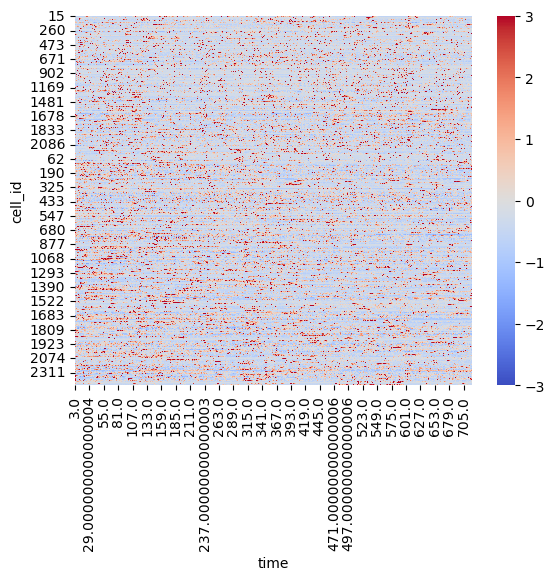

In [199]:
sns.heatmap(X.apply(scipy.stats.zscore).transpose(), vmin=-3, vmax=3, cmap="coolwarm")
plt.show()

In [205]:
session_name = "day4-test1"
traces_test1 = load_spike_proba(experiment="pfc", session_names=[session_name])
behaviour_test1 = load_behaviour(experiment="pfc", session_names=[session_name])
behaviour_test1["time"] = behaviour_test1["frame"].mul(1/30)
traces_by_mouse_test1 = split_by_mouse(experiment="pfc", df=traces_test1)
behaviour_by_mouse_test1 = split_by_mouse(experiment="pfc", df=behaviour_test1)

In [243]:
def preprocess(traces, behaviour, time_interval, behaviour_metric="freeze_status", round_metric: bool = True, time_col="time"):
    traces = pivot(traces)
    traces, behaviour = temporally_align_onep_behaviour(
    traces.reset_index(), behaviour[["time", behaviour_metric]], new_interval=time_interval
    )
    if round_metric:
        behaviour[behaviour_metric] = behaviour[behaviour_metric].round()
    X = traces.set_index("time")
    y = behaviour.set_index("time")["freeze_status"]
    X = X.dropna()
    y = y.reindex(X.index)
    return X, y

def fit_model(X, y, pipe):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)
    score = metrics.f1_score(y_test, y_hat)
    return score, pipe


def fit_model_per_mouse(pipe, traces_dict, behaviour_dict, cluster_neurons, group, time_interval="500ms"):
    all_scores = []
    all_groups = []
    all_mice = []
    all_models = []
    mice = list(behaviour_dict[group].keys())
    for mouse in mice:
        t = traces_dict[group][mouse]
        t = t
        b = behaviour_dict[group][mouse]
        X, y = preprocess(t, b, time_interval=time_interval)      
        try:
            cols = [c for c in X.columns if c in cluster_neurons]
            if len(cols) == 0:
                raise ValueError()
            X1 = X[cols]
            score, model = fit_model(X1, y, clone(pipe))
        except ValueError as e:
            print(str(e))
            score, model = np.nan, np.nan
        all_scores.append(score)
        all_models.append(model)
        all_mice.append(mouse)
        all_groups.append(group)
    return pd.DataFrame({"mouse": all_mice, "group": all_groups, "score": all_scores, "model": all_models})

In [244]:
res = fit_model_per_mouse(
    clone(pipe), 
    traces_by_mouse_test1, 
    behaviour_by_mouse_test1, 
    cluster_neurons=cluster1_units, 
    group="Experimental", 
    time_interval="500ms"
)

c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_timedelta(df[time_col], unit="s")
c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_timedelta(df[time_col], unit="s")
c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_timedelta(df[time_col], unit="s")


In [245]:
res

,mouse,group,score,model
0,B51628,Experimental,0.653061,"((DecisionTreeClassifier(max_features='auto', ..."
1,B51621,Experimental,0.055556,"((DecisionTreeClassifier(max_features='auto', ..."
2,B51620,Experimental,0.352941,"((DecisionTreeClassifier(max_features='auto', ..."
3,B51618,Experimental,0.696850,"((DecisionTreeClassifier(max_features='auto', ..."
4,B51619,Experimental,NaN,NaN


In [246]:
res = fit_model_per_mouse(
    clone(pipe), 
    traces_by_mouse_test1, 
    behaviour_by_mouse_test1, 
    cluster_neurons=cluster2_units, 
    group="Experimental", 
    time_interval="500ms"
)

c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_timedelta(df[time_col], unit="s")
c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_timedelta(df[time_col], unit="s")
c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

c:\users\roryl\repos\context_analysis\context_analysis\resample.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"] = pd.to_timedelta(df[time_col], unit="s")


In [247]:
res

,mouse,group,score,model
0,B51628,Experimental,0.402878,"((DecisionTreeClassifier(max_features='auto', ..."
1,B51621,Experimental,0.058824,"((DecisionTreeClassifier(max_features='auto', ..."
2,B51620,Experimental,0.367347,"((DecisionTreeClassifier(max_features='auto', ..."
3,B51618,Experimental,0.833333,"((DecisionTreeClassifier(max_features='auto', ..."
4,B51619,Experimental,NaN,NaN
